In [1]:
"""Data inspection."""

'Data inspection.'

In [76]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import sklearn

import torch
import numpy as np
import pickle
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets

PATH = '/scratch/users/nmiolane/output0226'
DEVICE='cuda'

In [77]:
# Data manipulation
import pickle
data_path = '/scratch/users/nmiolane/output0206'
with open(f'{data_path}/train.pkl', 'rb') as f:
    train = pickle.load(f)
with open(f'{data_path}/test.pkl', 'rb') as f:
    test = pickle.load(f)
#np.save('/scratch/users/nmiolane/train_64x64.npy', train)
#np.save('/scratch/users/nmiolane/test_64x64.npy', test)




In [81]:
train = np.load('/scratch/users/nmiolane/train_64x64.npy')
print(train.shape)
test = np.load('/scratch/users/nmiolane/test_64x64.npy')
print(test.shape)

train = np.load('/scratch/users/nmiolane/train_128x128.npy')
print(train.shape)
test = np.load('/scratch/users/nmiolane/test_128x128.npy')
print(test.shape)

train = np.load('/scratch/users/nmiolane/train_128x128_20slices.npy')
print(train.shape)
test = np.load('/scratch/users/nmiolane/test_128x128_20slices.npy')
print(test.shape)

(78228, 1, 64, 64)
(19558, 1, 64, 64)
(78228, 1, 128, 128)
(19558, 1, 128, 128)
(78228, 1, 64, 64)
(19558, 1, 64, 64)


Text(0.5, 1.0, 'Test Loss (Log scale)')

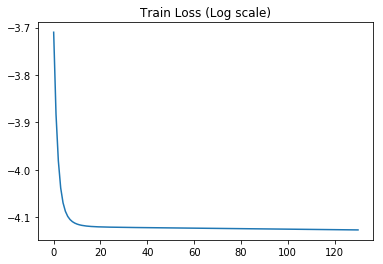

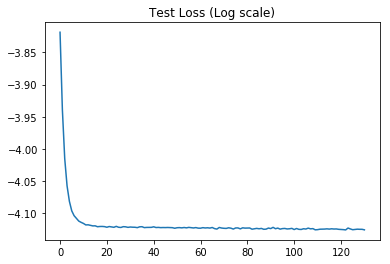

In [73]:
n_epoch = 130

train_losses = []
train_reconstruction_losses = []
train_regularization_losses = []

test_losses = []
test_reconstruction_losses = []
test_regularization_losses = []

for i in range(n_epoch+1):
    train_test = pickle.load(open(f'{PATH}/training/losses/epoch_{i}.pkl', 'rb'))
    train = train_test['train_losses']
    test = train_test['test_losses']
    
    train_losses.append(train['loss'])
    train_reconstruction_losses.append(train['loss_reconstruction'])
    train_regularization_losses.append(train['weighted_loss_regularization'])
    
    test_losses.append(test['loss'])
    test_reconstruction_losses.append(test['loss_reconstruction'])
    test_regularization_losses.append(test['weighted_loss_regularization'])

log_train_losses = np.log(train_losses)
log_test_losses = np.log(test_losses)

# TODO(nina): Log scale and loss additions    
plt.plot(log_train_losses)
plt.title('Train Loss (Log scale)')
plt.figure()
plt.plot(log_test_losses)
plt.title('Test Loss (Log scale)')

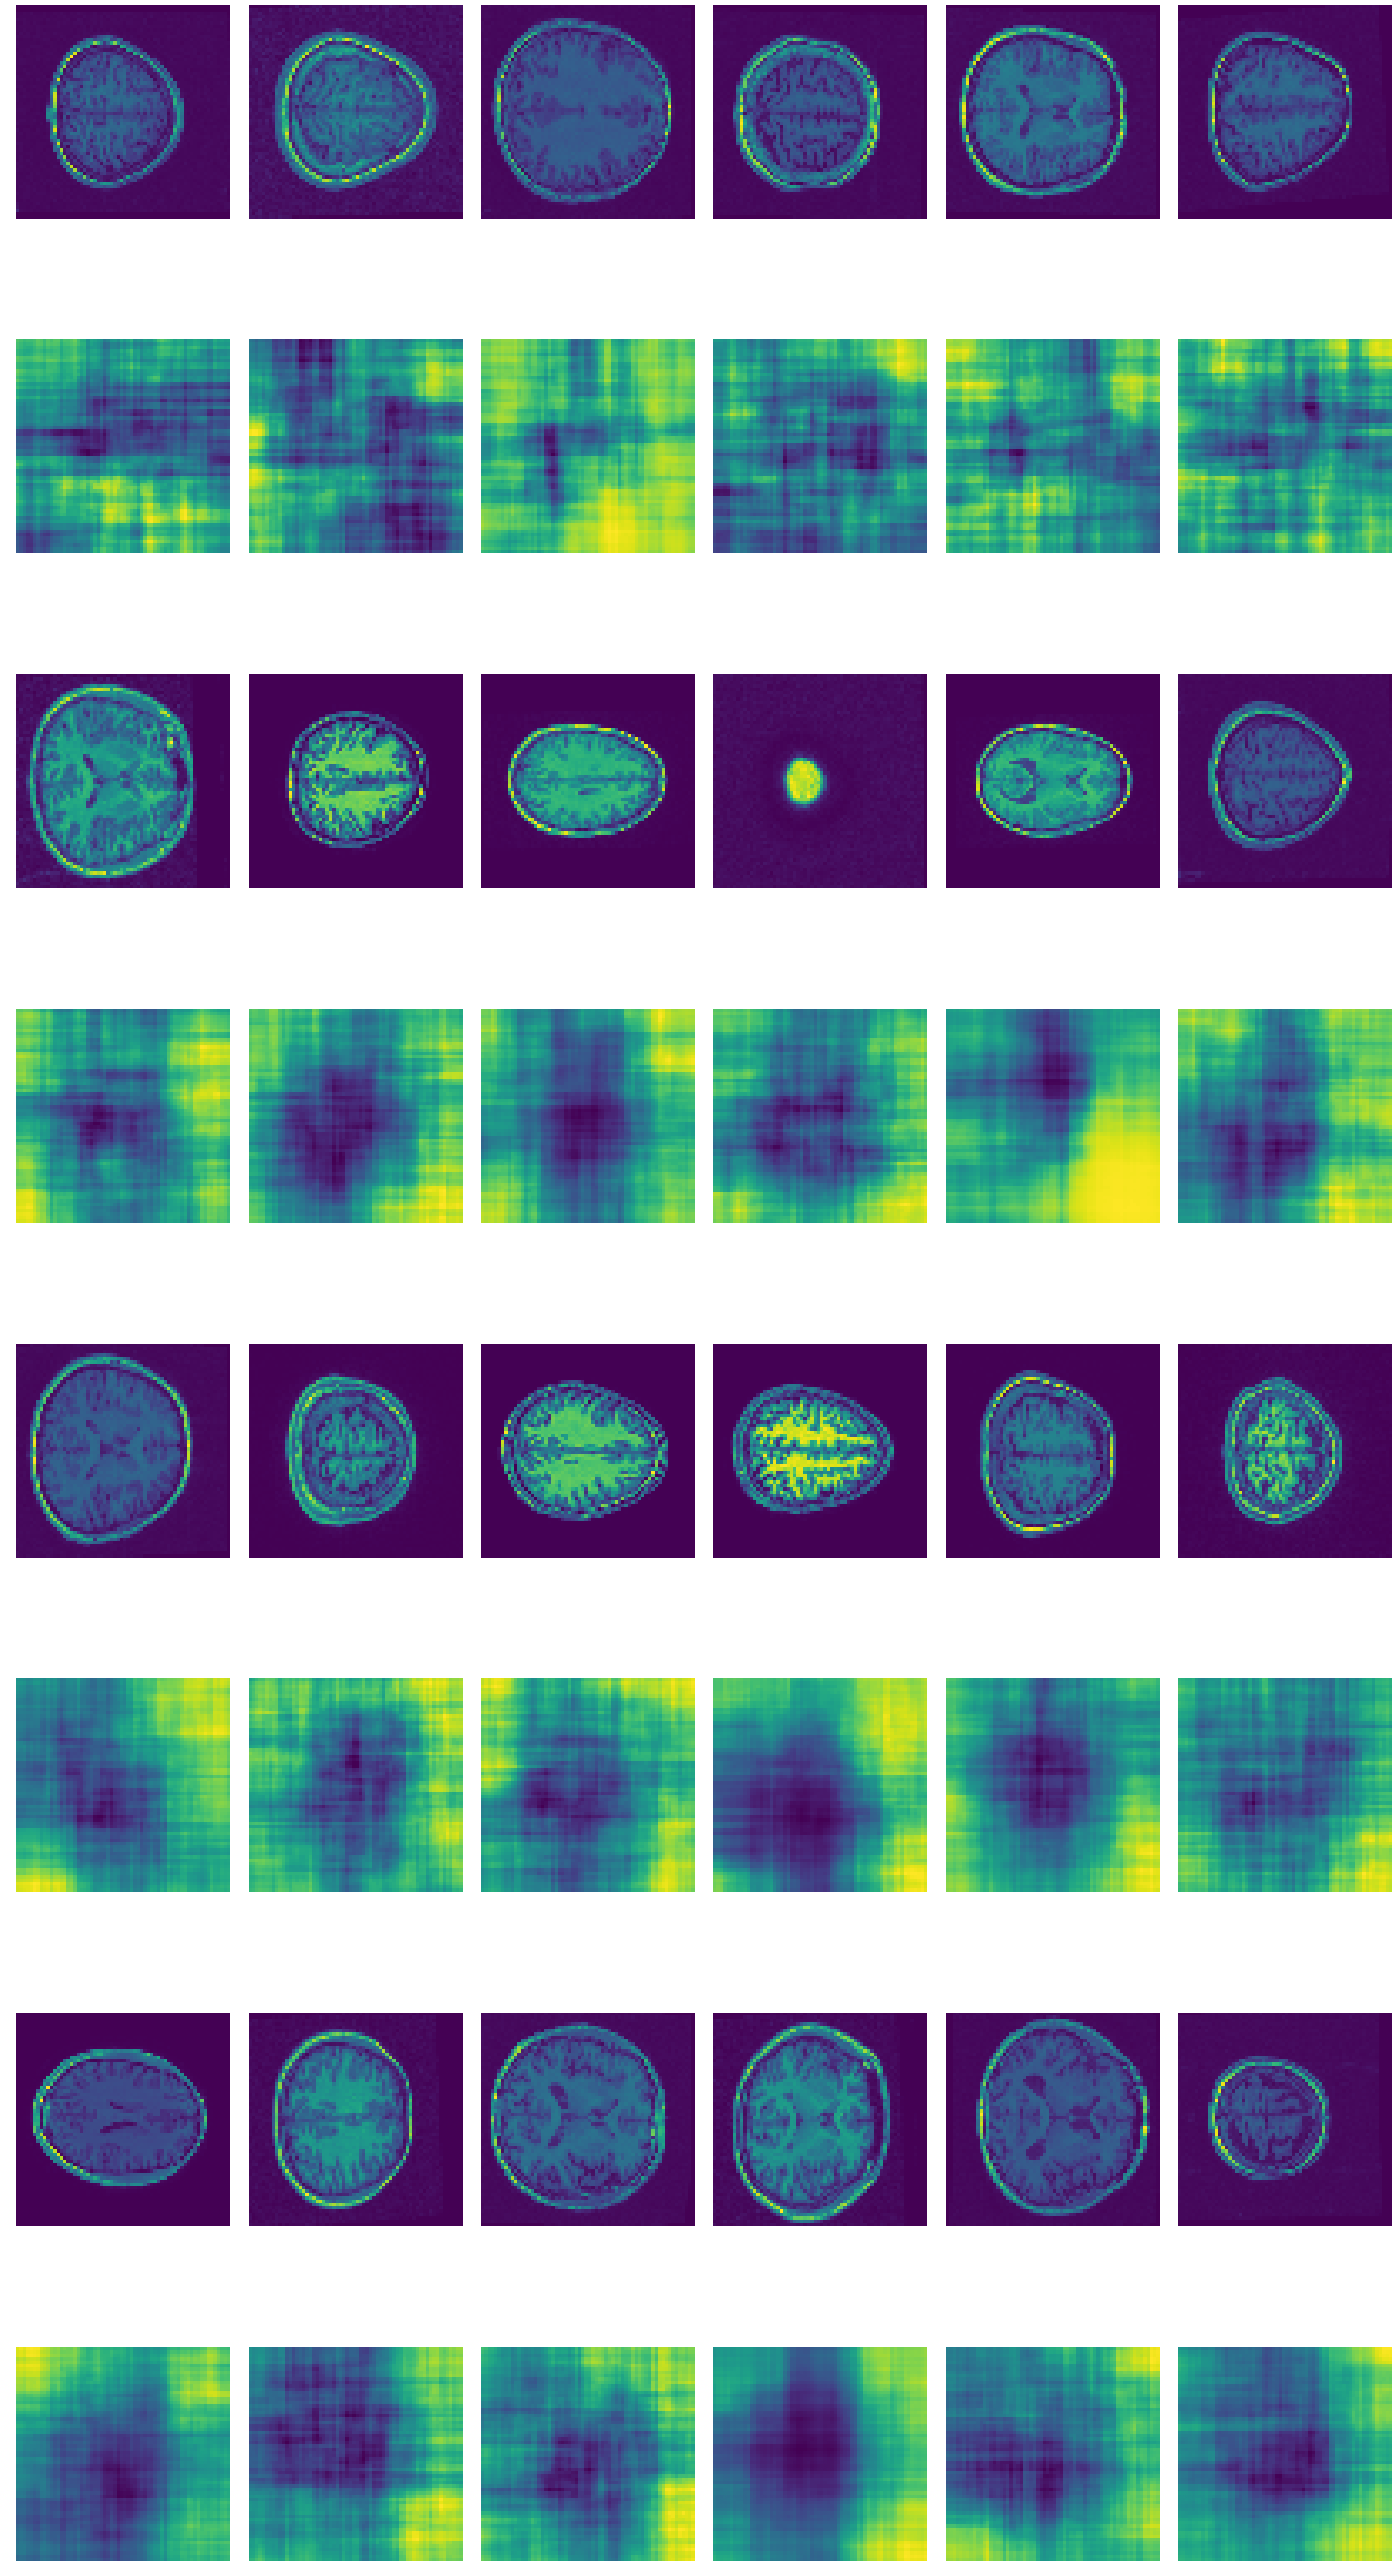

In [75]:
n_epochs = 129
n_imgs = 6
by = 43

n_tot = n_epochs / by + 1

fig = plt.figure(figsize=(8*n_tot, 16*n_tot))

for i in range(0, n_epochs+1, by):
    foo = np.load(f'{PATH}/training/imgs/epoch_{i}_data.npy')
    recon = np.load(f'{PATH}/training/imgs/epoch_{i}_recon.npy')

    for id in range(n_imgs):
        plt.subplot(2*n_tot, n_imgs, 2*i/by*n_imgs+id+1)
        plt.imshow(foo[id][0])
        plt.axis('off')
        plt.subplot(2*n_tot, n_imgs, 2*i/by*n_imgs+n_imgs+id+1)
        plt.imshow(recon[id][0])
        plt.axis('off')
        plt.tight_layout()

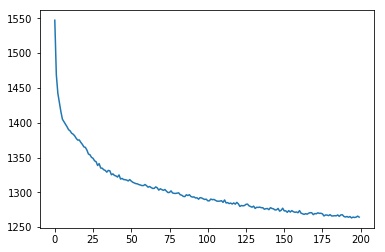

In [10]:
test = pickle.load(open(f'{PATH}/training/test_losses.pkl', 'rb'))
plt.plot(test)

In [33]:
def load_last_model():
    models = glob.glob(f'{PATH}/training/models/*.pth')
    model_ids = [(int(f.split('_')[1]), f) for f in models]
    start_epoch, last_cp = max(model_ids, key=lambda item:item[0])
    print('Last checkpoint: ', last_cp)
    model = torch.load(last_cp, map_location=DEVICE)
    return model

In [37]:
from sklearn.decomposition import PCA
N_COMPONENTS = 5

model = load_last_model()

test = np.load('/scratch/users/nmiolane/output/test.npy')

test = torch.Tensor(test)
test_dataset = torch.utils.data.TensorDataset(test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=True)

# Euclidean PCA on the Gaussian means learnt by the model
mus = []
for i, data in enumerate(test_loader):
    data = data[0].to(DEVICE)
    recon_batch, mu, logvar = model(data)
    mus.append(np.array(mu.cpu().detach()))

mus = np.array(mus).squeeze()

pca = PCA(n_components=N_COMPONENTS)
pca.fit(mus)
projected_mus = pca.transform(mus)

plt.scatter(projected_mus[:, 0], projected_mus[:, 1])

Last checkpoint:  /scratch/users/nmiolane/output/training/models/epoch_156_discriminator_train_loss_1220.6891_test_loss_1297.0680.pth
(19558, 1, 64, 64)


ValueError: not enough values to unpack (expected 3, got 1)

In [52]:
@interact(
    c1=FloatSlider(min=-6,max=6,step=0.1,value=0), 
    c2=FloatSlider(min=-6,max=6,step=0.1,value=0),
    c3=FloatSlider(min=-6,max=6,step=0.1,value=0),
    c4=FloatSlider(min=-6,max=6,step=0.1,value=0),
    c5=FloatSlider(min=-6,max=6,step=0.1,value=0))
def display_image(c1, c2, c3, c4, c5):
    z = (c1 * pca.components_[0] 
         + c2 * pca.components_[1]
         + c3 * pca.components_[2]
         + c4 * pca.components_[3]
         + c5 * pca.components_[4])
    z = torch.Tensor(z).cuda()
    recon = model.decode(z)
    recon = recon.squeeze()
    plt.imshow(recon.detach().cpu(), cmap='afmhot')

interactive(children=(FloatSlider(value=0.0, description='c1', max=6.0, min=-6.0), FloatSlider(value=0.0, desc…

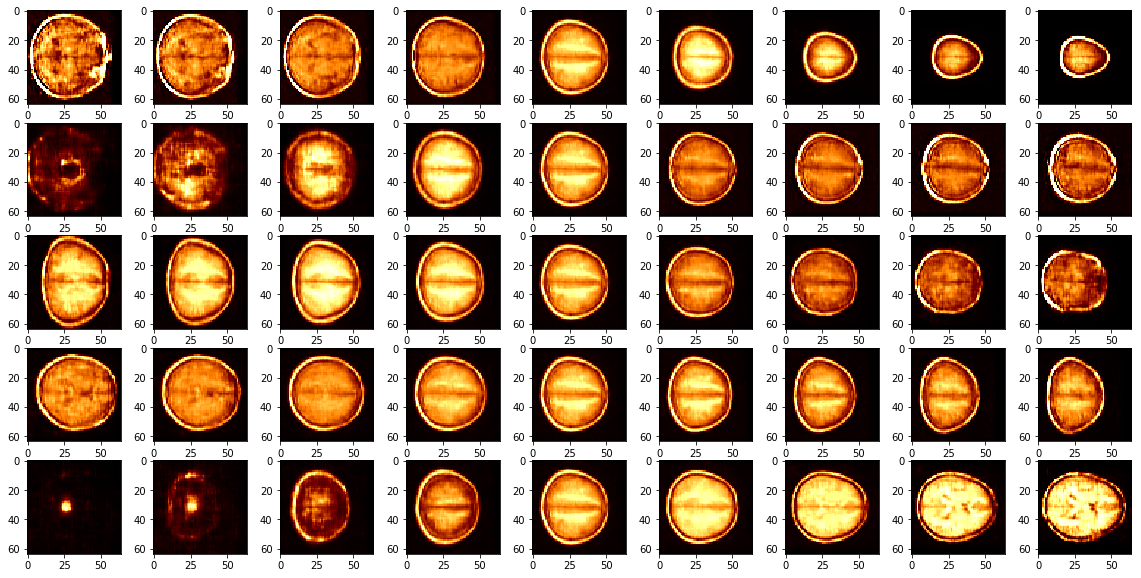

In [62]:
fig = plt.figure(figsize=(20, 10))
plt.tight_layout()
r = 4
n_cols = 2 * r + 1 

for id in range(N_COMPONENTS):
    for slider in range(-r, r+1, 1):
        plt.subplot(N_COMPONENTS, n_cols, n_cols * id + slider + r + 1)
        z = slider * pca.components_[id]
        z = torch.Tensor(z).cuda()
        recon = model.decode(z)
        recon = recon.squeeze()
        plt.imshow(recon.detach().cpu(), cmap='afmhot')